In [126]:
import polars as pl
import polars.selectors as cs
import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# import prettytable
import prettytable

# =============================================================================
# PUBLICATION-QUALITY PLOT SETTINGS
# =============================================================================

# 1. Color palette - distinct, colorblind-friendly colors
COLORS = {
    'pause': '#1f77b4',         # Blue
    'plank': '#2ca02c',         # Green  
    'push-up': '#ff7f0e',       # Orange
    'russian-twist': '#9467bd', # Purple
    'squat': '#d62728'          # Red
}

# 3. Typography & Font Sizes
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

In [127]:
# DEFAULT PARAMETERS USED FOR FINETUNING
# DO NOT CHANGE
BUFFER_SIZE_SECONDS = 5
PREDICTION_INTERVAL = 0.15
WARMUP_TIME = max(2.0, BUFFER_SIZE_SECONDS + 0.2)
CONFIDENCE_THRESHOLD = 0.95
ALPHA = 0.8
TIMEOUT = 0.8
NUM_FRAMES = 8
TEMPERATURE = 1

In [128]:
VIDEO_1_LIMITS = ([0, 44], "pause", "pause")
VIDEO_2_LIMITS = ([10, 21.5], "russian-twist", "front russian-twist") # Front 
VIDEO_3_LIMITS = ([10, 22], "russian-twist", "side russian-twist") # Side
VIDEO_4_LIMITS = ([10, 20.5], "squat", "front squat") # Front
VIDEO_5_LIMITS = ([13, 25], "plank", "side plank") # Side
VIDEO_6_LIMITS = ([11, 24], "plank", "front plank") # Front
VIDEO_7_LIMITS = ([11, 24], "push-up", "front push-up") # Front
VIDEO_8_LIMITS = ([12, 25], "push-up", "side push-up") # Side
VIDEO_9_LIMITS = ([10, 20], "squat", "side squat") # Side
VIDEO_10_LIMITS = ([10, 24], "squat", "back squat") # Back
VIDEO_11_LIMITS = ([10, 30], "squat", "front squat") # Front


video_limits = [globals()[f"VIDEO_{i}_LIMITS"] for i in range(1, 12)]

N_VIDEOS = len(video_limits)

# Substract WARMUP_TIME from thresholds
for limits in video_limits:
    limits[0][0] = max(limits[0][0]-WARMUP_TIME, 0)
    limits[0][1] = max(limits[0][1]-WARMUP_TIME, 0)


In [155]:
def to_seconds(ts):
    # Handles both "HH:MM:SS.sss..." and "HH:MM:SS.ssssss" formats
    if "." in ts:
        t, ms = ts.split(".", 1)
        ms = "0." + ms
    else:
        t = ts
        ms = "0"
    h, m, s = map(int, t.split(":"))
    base = h * 3600 + m * 60 + s
    return base + float(ms)

def plot_with_prediction(df, ax, limits=None, label=None, confidence_threshold=None, 
                         show_legend=True, iou=None, wrong_pct=None):
    """
    Publication-ready prediction visualization plot.
    
    Improvements:
    - Consistent color palette (COLORS dict)
    - Thicker lines with better visibility
    - Subtle grid for readability
    - Ground truth shaded region
    - Clean title with metrics as annotation
    """
    
    df = df.with_columns(
        pl.col("timestamp")
        .map_elements(to_seconds, return_dtype=pl.Float32)
        .alias("timestamp_sec")
    ).with_columns(
        pl.col("timestamp_sec").sub(pl.col("timestamp_sec").min())
    )

    # Only plot pause if that is the label
    if label != "pause":
        df = df.drop("prob_pause")

    prob_cols = df.select(cs.starts_with("prob_")).columns
    timestamps = df["timestamp_sec"].to_numpy()

    # 7. Plot ground truth region first (behind everything)
    if limits is not None:
        ax.axvspan(limits[0], limits[1], color='#e8e8e8', alpha=0.6, 
                   label='Target Interval', zorder=0)

    # 1 & 4. Plot lines with consistent colors and thicker linewidth
    lines = []
    for col in prob_cols:
        exercise = col.split("_")[1]
        color = COLORS.get(exercise, '#888888')
        
        line, = ax.plot(
            timestamps, 
            df[col].to_numpy(),
            label=exercise.replace('-', ' ').title(),
            color=color,
            linewidth=2.0,  # 4. Thicker lines
            alpha=0.85,
            zorder=2
        )
        lines.append(line)

    # Add faded background for high-confidence predictions
    if confidence_threshold is not None:
        for col, line in zip(prob_cols, lines):
            color = line.get_color()
            
            # Find continuous intervals above threshold
            above_threshold = df[col] >= confidence_threshold
            
            # Find interval boundaries
            in_interval = False
            start_idx = None
            
            for i, is_above in enumerate(above_threshold):
                if is_above and not in_interval:
                    in_interval = True
                    start_idx = i
                elif not is_above and in_interval:
                    in_interval = False
                    # Only plot if interval duration is at least 0.01s
                    start = timestamps[start_idx]
                    end = timestamps[i-1]
                    if end - start >= 0.01:
                        ax.axvspan(start, end, color=color, alpha=0.15, zorder=1)
            
            # Handle case where interval extends to the end
            if in_interval:
                ax.axvspan(timestamps[start_idx], timestamps[-1], 
                          color=color, alpha=0.15, zorder=1)

    # Draw dashed vertical lines at the interval boundaries
    if limits is not None:
        ax.axvline(x=limits[0], color='#333333', linestyle=':', linewidth=1.5, alpha=0.8)
        ax.axvline(x=limits[1], color='#333333', linestyle=':', linewidth=1.5, alpha=0.8)
        
    # Confidence threshold line
    if confidence_threshold is not None:
        ax.axhline(y=confidence_threshold, color='#c0392b', linestyle='--', 
                   linewidth=1.5, alpha=0.7)

    # 8. Improved title format - clean title with metrics as annotation
    display_label = label.replace('-', ' ').title() if label else ""
    ax.set_title(display_label, fontweight='bold', pad=10)
    
    # Add metrics as text annotation (top-right corner)
    if iou is not None and wrong_pct is not None:
        metrics_text = f"IoU: {iou:.2f}  •  Wrong: {wrong_pct:.1f}%"
        ax.text(0.98, 0.95, metrics_text,
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='#cccccc', alpha=0.9))

    # Axis formatting
    ax.set_ylim(0, 1.02)
    ax.set_xlim(timestamps[0], timestamps[-1])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Probability")
    
    # 6. Add subtle grid
    ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5, zorder=0)
    
    # Clean x-axis ticks
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=False))
    
    # Legend
    if show_legend:
        ax.legend(loc='lower right', framealpha=0.9, fancybox=False, 
                  edgecolor='#cccccc')
    
    return ax

In [156]:
def calculate_iou(
    df: pl.DataFrame, 
    limits: tuple[float, float], 
    label: str, 
    confidence_threshold: float
):
    df = df.with_columns(
        pl.col("timestamp")
        .map_elements(to_seconds, return_dtype=pl.Float32)
        .alias("timestamp_sec")
    ).with_columns(
        pl.col("timestamp_sec").sub(pl.col("timestamp_sec").min())
    )
    ts = df["timestamp_sec"].to_numpy()
    
    if label == "pause":
        # Set scores=1 when all other prediction probs are below confidence_threshold, else use the normal pause prob
        mask_below = df.drop("timestamp_sec").with_columns(
           pl.sum_horizontal(cs.starts_with("prob_").exclude("prob_pause") > CONFIDENCE_THRESHOLD)
           .cast(pl.Boolean)
           .not_()
           .cast(pl.Float32)
           .alias("prob_pause")
        )

        scores = mask_below["prob_pause"].to_numpy()

    else:
        scores = df[f"prob_{label}"].to_numpy()
    
    above = scores >= confidence_threshold
    
    # Find all separate intervals where predictions are above threshold
    # Each sample represents the prediction until the next sample
    pred_intervals = []
    in_interval = False
    start_idx = None
    
    for i, is_above in enumerate(above):
        if is_above and not in_interval:
            # Start of new interval
            in_interval = True
            start_idx = i
        elif not is_above and in_interval:
            # End of interval
            in_interval = False
            # End at ts[i], not ts[i-1], because the prediction extends until
            # the next sample shows it's below threshold
            pred_intervals.append((ts[start_idx], ts[i]))
    
    # Handle case where interval extends to the end
    if in_interval:
        pred_intervals.append((ts[start_idx], ts[-1]))
    
    if len(pred_intervals) == 0:
        return 0.0
    
    gt_start, gt_end = limits
    
    # Calculate intersection: sum of overlaps between each predicted interval and GT
    total_intersection = 0.0
    for pred_start, pred_end in pred_intervals:
        inter = max(0, min(pred_end, gt_end) - max(pred_start, gt_start))
        total_intersection += inter
    
    # Calculate union: GT interval + predicted intervals - intersections
    # First, merge overlapping predicted intervals
    merged_pred = []
    for start, end in sorted(pred_intervals):
        if merged_pred and start <= merged_pred[-1][1]:
            merged_pred[-1] = (merged_pred[-1][0], max(merged_pred[-1][1], end))
        else:
            merged_pred.append((start, end))
    
    # Total predicted coverage
    pred_coverage = sum(end - start for start, end in merged_pred)
    
    # GT coverage
    gt_coverage = gt_end - gt_start
    
    # Union = GT + pred - intersection (but need to compute intersection of merged intervals)
    merged_intersection = 0.0
    for pred_start, pred_end in merged_pred:
        inter = max(0, min(pred_end, gt_end) - max(pred_start, gt_start))
        merged_intersection += inter
    
    union = gt_coverage + pred_coverage - merged_intersection
    
    return total_intersection / union if union > 0 else 0.0

In [157]:
def calculate_wrong_prediction_percentage(
    df: pl.DataFrame,
    label: str,
    confidence_threshold: float
):
    """
    Calculate the percentage of time in the video that the model is predicting
    the wrong label (excluding pause - predicting pause is better than wrong movements).
    
    Returns: percentage (0-100) of video time with confident wrong predictions
    """
    df = df.with_columns(
        pl.col("timestamp")
        .map_elements(to_seconds, return_dtype=pl.Float32)
        .alias("timestamp_sec")
    ).with_columns(
        pl.col("timestamp_sec").sub(pl.col("timestamp_sec").min())
    )
    ts = df["timestamp_sec"].to_numpy()

    # Set pause=1 when all other prediction probs are below confidence_threshold
    df = df.with_columns(
        pl.sum_horizontal(cs.starts_with("prob_").exclude("prob_pause") > CONFIDENCE_THRESHOLD)
        .cast(pl.Boolean)
        .not_()
        .cast(pl.Float32)
        .alias("prob_pause")
    )

    # Total video duration
    total_duration = ts[-1] - ts[0]
    if total_duration <= 0:
        return 0.0
    
    # Get all probability columns
    prob_cols = df.select(cs.starts_with("prob_")).columns
    
    # Find columns for wrong predictions (exclude correct label and pause)
    wrong_cols = [col for col in prob_cols 
                  if col != f"prob_{label}" and col != "prob_pause"]
    
    if not wrong_cols:
        return 0.0
    
    # Check if ANY wrong prediction is above threshold at each timestep
    wrong_above = np.zeros(len(df), dtype=bool)
    for col in wrong_cols:
        scores = df[col].to_numpy()
        wrong_above |= (scores >= confidence_threshold)
    
    # Find all separate intervals where wrong predictions are above threshold
    # Each sample represents the prediction until the next sample
    wrong_intervals = []
    in_interval = False
    start_idx = None
    
    for i, is_above in enumerate(wrong_above):
        if is_above and not in_interval:
            in_interval = True
            start_idx = i
        elif not is_above and in_interval:
            in_interval = False
            # End at ts[i], not ts[i-1], because the wrong prediction extends until
            # the next sample shows it's below threshold
            wrong_intervals.append((ts[start_idx], ts[i]))
    
    # Handle case where interval extends to the end
    if in_interval:
        wrong_intervals.append((ts[start_idx], ts[-1]))
    
    if len(wrong_intervals) == 0:
        return 0.0
    
    # Merge overlapping intervals
    merged = []
    for start, end in sorted(wrong_intervals):
        if merged and start <= merged[-1][1]:
            merged[-1] = (merged[-1][0], max(merged[-1][1], end))
        else:
            merged.append((start, end))
    
    # Total time with wrong predictions
    wrong_time = sum(end - start for start, end in merged)
    
    return (wrong_time / total_duration) * 100

In [158]:
def make_plots(
    model_name: str, 
    fig = None, 
    ax = None, 
    exp_alpha = 1.0,
    confidence_threshold = CONFIDENCE_THRESHOLD,
    temperature = "1.0",
    show_legend = True,
    sample_rows = None
):
    """Generate publication-ready prediction plots for all videos."""

    if fig is None:
        fig, ax = plt.subplots(nrows=N_VIDEOS, figsize=(12, N_VIDEOS*6))

    if sample_rows is not None:
        np.random.seed(0)
        sample_rows = np.random.choice(N_VIDEOS, sample_rows, replace=False)
        sample_rows = sorted(sample_rows)
    else:
        sample_rows = range(N_VIDEOS)

    for idx, i in enumerate(sample_rows):

        try:
            df = pl.read_csv(f"manual_inspection/results/{model_name}_{i+1}_temperature={temperature}.csv", separator=";")
        except FileNotFoundError:
            df = pl.read_csv(f"manual_inspection/results/{model_name}_{i+1}.csv", separator=";")

        df = df.sort("timestamp")

        df = df.with_columns(
            cs.starts_with("prob_").ewm_mean(alpha=exp_alpha)
        )

        iou = calculate_iou(df, video_limits[i][0], video_limits[i][1], confidence_threshold)
        wrong_pct = calculate_wrong_prediction_percentage(df, video_limits[i][1], confidence_threshold)
        
        # Pass IoU and wrong_pct to the plotting function for annotation
        ax[idx] = plot_with_prediction(
            df, 
            ax[idx], 
            limits=video_limits[i][0], 
            label=video_limits[i][2], 
            confidence_threshold=confidence_threshold,
            show_legend=show_legend,
            iou=iou,
            wrong_pct=wrong_pct
        )
    
    return fig, ax

(<Figure size 3600x7200 with 16 Axes>,
 array([<Axes: title={'center': 'Front Russian Twist'}, xlabel='Time (s)', ylabel='Probability'>,
        <Axes: title={'center': 'Side Russian Twist'}, xlabel='Time (s)', ylabel='Probability'>,
        <Axes: title={'center': 'Side Plank'}, xlabel='Time (s)', ylabel='Probability'>,
        <Axes: title={'center': 'Front Push Up'}, xlabel='Time (s)', ylabel='Probability'>,
        <Axes: title={'center': 'Side Push Up'}, xlabel='Time (s)', ylabel='Probability'>,
        <Axes: title={'center': 'Side Squat'}, xlabel='Time (s)', ylabel='Probability'>,
        <Axes: title={'center': 'Back Squat'}, xlabel='Time (s)', ylabel='Probability'>,
        <Axes: title={'center': 'Front Squat'}, xlabel='Time (s)', ylabel='Probability'>],
       dtype=object))

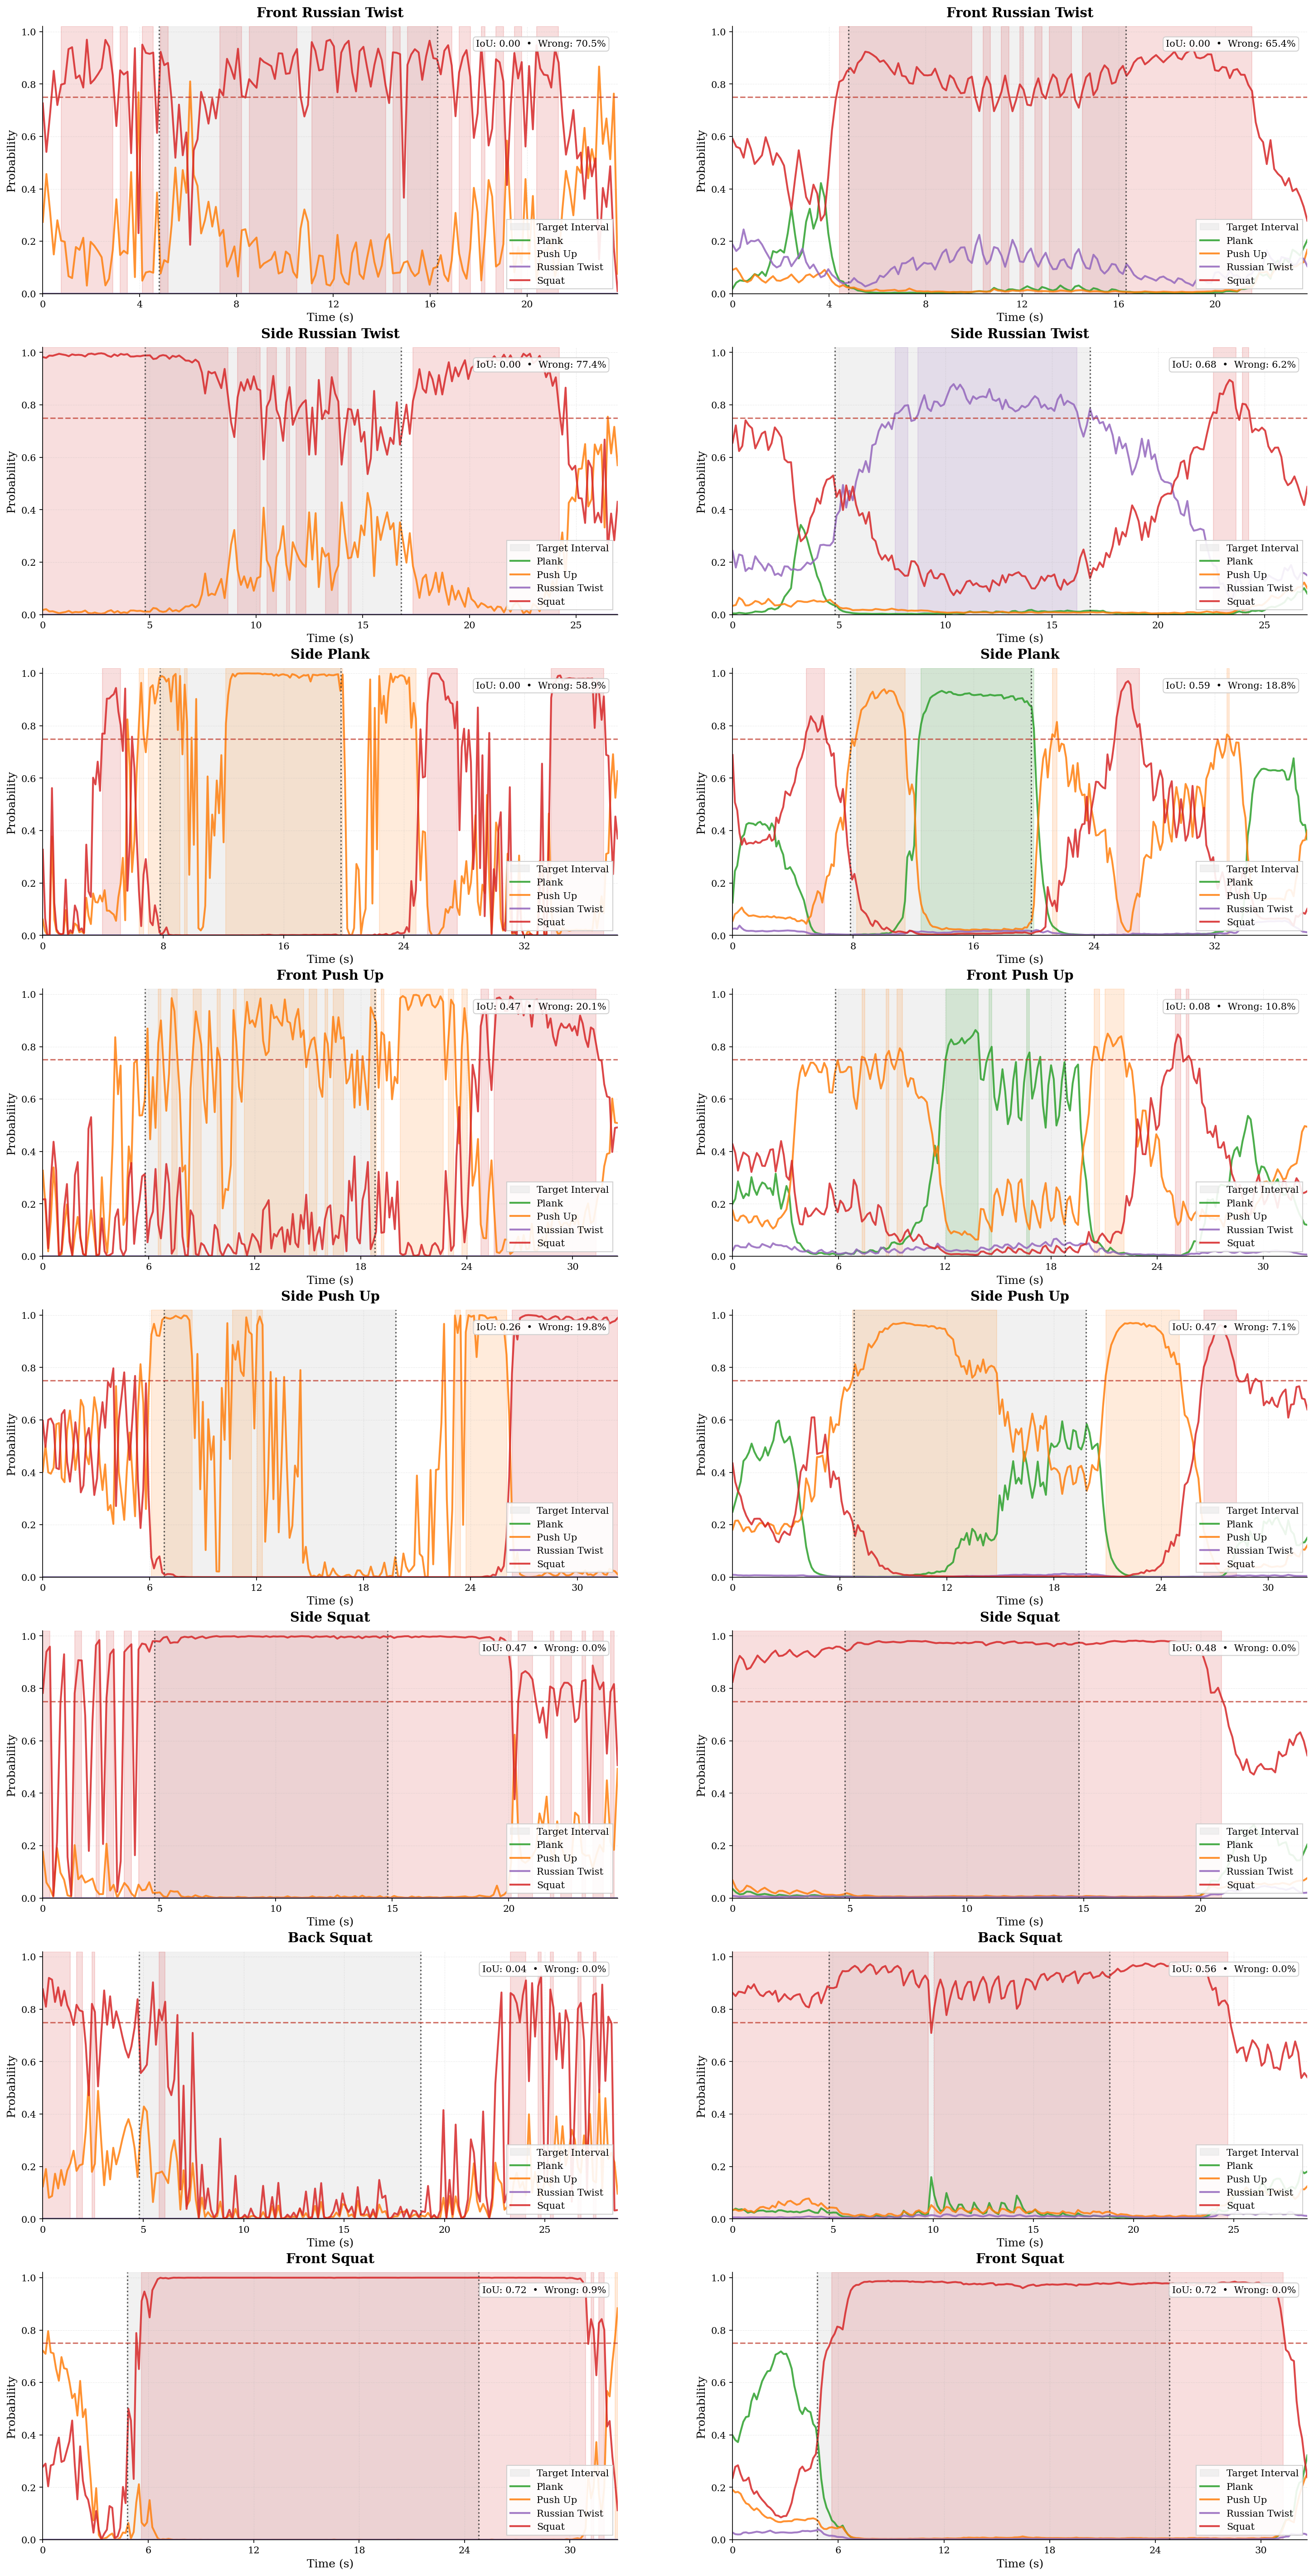

In [160]:
# sample_rows = N_VIDEOS
sample_rows = 8

fig, ax = plt.subplots(nrows=sample_rows, ncols=2, figsize=(12*2, sample_rows*6))
ax = ax.flatten(order="F")

make_plots(
    "pretrained", 
    fig, 
    ax[:sample_rows], 
    confidence_threshold=0.75, 
    sample_rows=sample_rows
)
make_plots(
    "timesformer_max_full_even_6", 
    fig, 
    ax[sample_rows:], 
    confidence_threshold=0.75, 
    temperature="1.3", 
    exp_alpha=0.5, 
    sample_rows=sample_rows
)




In [114]:
def calculate_metrics_table(
    model_name: str,
    confidence_threshold = CONFIDENCE_THRESHOLD,
    temperature = "1.0",
    exp_alpha = 1.0
):
    # Collect IoU values and wrong prediction percentage for the table
    results = []

    for i in range(N_VIDEOS):
        try:
            df = pl.read_csv(f"manual_inspection/results/{model_name}_{i+1}_temperature={temperature}.csv", separator=";")
        except FileNotFoundError:
            df = pl.read_csv(f"manual_inspection/results/{model_name}_{i+1}.csv", separator=";")

        df = df.sort("timestamp")
        df = df.with_columns(
            cs.starts_with("prob_").ewm_mean(alpha=exp_alpha)
        )

        iou = calculate_iou(df, video_limits[i][0], video_limits[i][1], confidence_threshold)
        wrong_pct = calculate_wrong_prediction_percentage(df, video_limits[i][1], confidence_threshold)
        results.append({
            "video": i + 1,
            "label": video_limits[i][2],
            "exercise": video_limits[i][1],
            "iou": iou,
            "wrong_pct": wrong_pct
        })
        
    
    # Create a pretty table with IoU and Wrong Prediction %
    table = prettytable.PrettyTable()
    table.field_names = ["Video #", "Description", "Exercise Class", "IoU", "Wrong %"]

    # Style the table
    table.align["Description"] = "l"
    table.align["Exercise Class"] = "l"
    table.align["IoU"] = "r"
    table.align["Wrong %"] = "r"
    table.float_format["IoU"] = ".3"
    table.float_format["Wrong %"] = ".1"

    for result in results:
        table.add_row([
            result["video"],
            result["label"],
            result["exercise"],
            f"{result['iou']:.3f}",
            f"{result['wrong_pct']:.1f}"
        ])

    # Add a separator and summary row
    table.add_row(["─" * 3, "─" * 18, "─" * 14, "─" * 6, "─" * 7])
    mean_iou = np.mean([r["iou"] for r in results])
    mean_wrong = np.mean([r["wrong_pct"] for r in results])
    table.add_row(["", "MEAN", "", f"{mean_iou:.3f}", f"{mean_wrong:.1f}"])

    return table, [r["iou"] for r in results], [r["wrong_pct"] for r in results]


In [122]:
print("Pretrained")
table, ious, wrongs = calculate_metrics_table("pretrained", confidence_threshold=0.75)
print(f"IoU: {np.mean(ious):.3f} ({np.std(ious):.3f}) - Wrong: {np.mean(wrongs):.1f} ({np.std(wrongs):.1f})")
print(table)

print("timesformer-max-full-even-6")
table, ious, wrongs = calculate_metrics_table("timesformer_max_full_even_6", confidence_threshold=0.75, temperature="1.3", exp_alpha=0.3)
print(f"IoU: {np.mean(ious):.3f} ({np.std(ious):.3f}) - Wrong: {np.mean(wrongs):.1f} ({np.std(wrongs):.1f})")
print(table)


Pretrained
IoU: 0.302 (0.295) - Wrong: 34.9 (32.6)
+---------+---------------------+----------------+--------+---------+
| Video # | Description         | Exercise Class |    IoU | Wrong % |
+---------+---------------------+----------------+--------+---------+
|    1    | pause               | pause          |  0.722 |    48.6 |
|    2    | front russian-twist | russian-twist  |  0.000 |    70.5 |
|    3    | side russian-twist  | russian-twist  |  0.000 |    77.4 |
|    4    | front squat         | squat          |  0.651 |     1.2 |
|    5    | side plank          | plank          |  0.000 |    58.9 |
|    6    | front plank         | plank          |  0.000 |    86.3 |
|    7    | front push-up       | push-up        |  0.470 |    20.1 |
|    8    | side push-up        | push-up        |  0.255 |    19.8 |
|    9    | side squat          | squat          |  0.469 |     0.0 |
|    10   | back squat          | squat          |  0.042 |     0.0 |
|    11   | front squat         | squat

In [118]:
for temperature in np.arange(0.7, 1.31, 0.1):
    temperature = str(round(temperature, 2))
    for threshold in np.arange(0.5, 1.0, 0.1):
        for exp_alpha in [0.3, 0.5, 0.7, 1.0]:
            threshold = round(threshold, 2)
            exp_alpha = round(exp_alpha, 2)
            
            table, ious, wrongs = calculate_metrics_table("timesformer_max_full_even_6", confidence_threshold=threshold, temperature=temperature, exp_alpha=exp_alpha)
        
            if np.mean(ious) > 0.500 and np.mean(wrongs) < 30.0:
                print(f"Temperature: {temperature} - Threshold: {threshold} - Exp Alpha: {exp_alpha}")
                print(f"IoU: {np.mean(ious):.3f} ({np.std(ious):.3f}) - Wrong: {np.mean(wrongs):.1f} ({np.std(wrongs):.1f})")
                print(table)

Temperature: 0.9 - Threshold: 0.8 - Exp Alpha: 0.3
IoU: 0.502 (0.214) - Wrong: 20.2 (21.2)
+---------+---------------------+----------------+--------+---------+
| Video # | Description         | Exercise Class |    IoU | Wrong % |
+---------+---------------------+----------------+--------+---------+
|    1    | pause               | pause          |  0.797 |    42.6 |
|    2    | front russian-twist | russian-twist  |  0.000 |    73.0 |
|    3    | side russian-twist  | russian-twist  |  0.725 |    17.0 |
|    4    | front squat         | squat          |  0.506 |     0.0 |
|    5    | side plank          | plank          |  0.576 |    24.8 |
|    6    | front plank         | plank          |  0.501 |    29.4 |
|    7    | front push-up       | push-up        |  0.243 |    15.5 |
|    8    | side push-up        | push-up        |  0.473 |    15.7 |
|    9    | side squat          | squat          |  0.468 |     0.0 |
|    10   | back squat          | squat          |  0.533 |     0.0 |

(<Figure size 1600x4400 with 55 Axes>,
 array([[<Axes: title={'center': 'Video 1: pause\nIoU & Wrong% vs Threshold'}, xlabel='Confidence Threshold', ylabel='IoU'>,
         <Axes: title={'center': 'Trade-off: IoU vs Wrong%'}, xlabel='Wrong %', ylabel='IoU'>,
         <Axes: title={'center': 'Quality Score vs Threshold'}, xlabel='Confidence Threshold', ylabel='Quality Score (IoU - Wrong%/100)'>],
        [<Axes: title={'center': 'Video 2: front russian-twist\nIoU & Wrong% vs Threshold'}, xlabel='Confidence Threshold', ylabel='IoU'>,
         <Axes: title={'center': 'Trade-off: IoU vs Wrong%'}, xlabel='Wrong %', ylabel='IoU'>,
         <Axes: title={'center': 'Quality Score vs Threshold'}, xlabel='Confidence Threshold', ylabel='Quality Score (IoU - Wrong%/100)'>],
        [<Axes: title={'center': 'Video 3: side russian-twist\nIoU & Wrong% vs Threshold'}, xlabel='Confidence Threshold', ylabel='IoU'>,
         <Axes: title={'center': 'Trade-off: IoU vs Wrong%'}, xlabel='Wrong %', ylabel='I

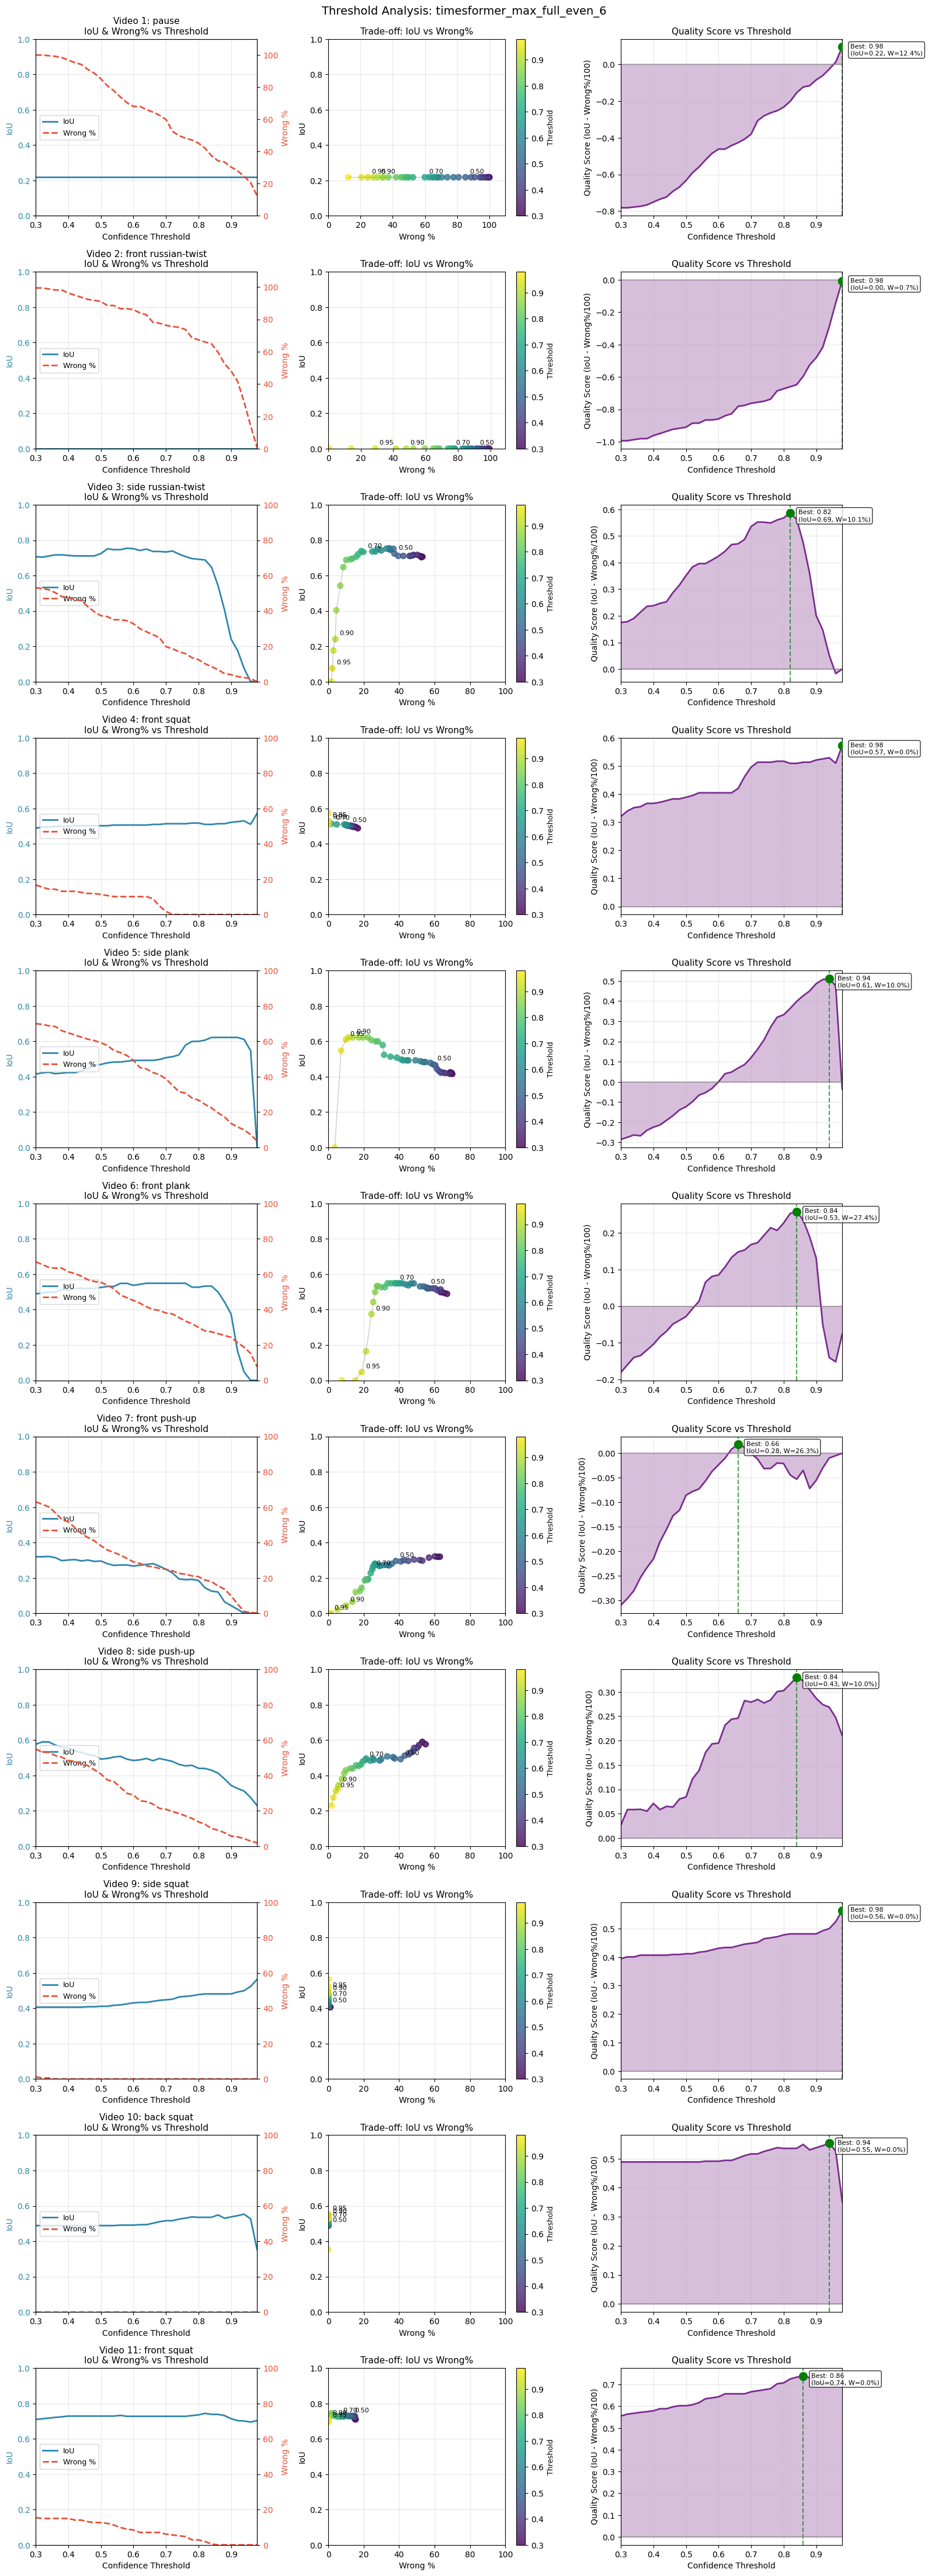

In [19]:
def plot_threshold_analysis(
    model_name: str,
    thresholds: np.ndarray = None,
    figsize: tuple = (16, 4 * 11)  # 11 videos
):
    """
    For each video, plot how IoU and Wrong% change with confidence threshold.
    
    Creates 3 subplots per video:
    1. Dual-axis: IoU and Wrong% vs Threshold
    2. Trade-off curve: IoU vs Wrong% (parametrized by threshold)
    3. Combined metric: IoU - Wrong%/100 vs Threshold (a simple "quality" score)
    """
    if thresholds is None:
        thresholds = np.arange(0.3, 0.99, 0.02)
    
    fig, axes = plt.subplots(nrows=N_VIDEOS, ncols=3, figsize=figsize)
    
    for video_idx in range(N_VIDEOS):
        # Load data for this video
        df = pl.read_csv(f"manual_inspection/results/{model_name}_{video_idx+1}.csv", separator=";")
        df = df.sort("timestamp")
        
        limits = video_limits[video_idx][0]
        label = video_limits[video_idx][1]
        description = video_limits[video_idx][2]
        
        # Calculate IoU and Wrong% for each threshold
        ious = []
        wrong_pcts = []
        
        for thresh in thresholds:
            iou = calculate_iou(df, limits, label, thresh)
            wrong_pct = calculate_wrong_prediction_percentage(df, label, thresh)
            ious.append(iou)
            wrong_pcts.append(wrong_pct)
        
        ious = np.array(ious)
        wrong_pcts = np.array(wrong_pcts)
        
        # --- Plot 1: Dual-axis (IoU and Wrong% vs Threshold) ---
        ax1 = axes[video_idx, 0]
        
        color_iou = '#2E86AB'  # Blue
        color_wrong = '#E94F37'  # Red
        
        line1, = ax1.plot(thresholds, ious, color=color_iou, linewidth=2, label='IoU')
        ax1.set_xlabel('Confidence Threshold', fontsize=10)
        ax1.set_ylabel('IoU', color=color_iou, fontsize=10)
        ax1.tick_params(axis='y', labelcolor=color_iou)
        ax1.set_ylim(0, 1)
        ax1.set_xlim(thresholds[0], thresholds[-1])
        
        ax1_twin = ax1.twinx()
        line2, = ax1_twin.plot(thresholds, wrong_pcts, color=color_wrong, linewidth=2, linestyle='--', label='Wrong %')
        ax1_twin.set_ylabel('Wrong %', color=color_wrong, fontsize=10)
        ax1_twin.tick_params(axis='y', labelcolor=color_wrong)
        ax1_twin.set_ylim(0, max(100, wrong_pcts.max() * 1.1))
        
        ax1.set_title(f'Video {video_idx+1}: {description}\nIoU & Wrong% vs Threshold', fontsize=11)
        ax1.legend([line1, line2], ['IoU', 'Wrong %'], loc='center left', fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # --- Plot 2: Trade-off curve (IoU vs Wrong%) ---
        ax2 = axes[video_idx, 1]
        
        # Color by threshold
        scatter = ax2.scatter(wrong_pcts, ious, c=thresholds, cmap='viridis', s=50, alpha=0.8)
        ax2.plot(wrong_pcts, ious, color='gray', alpha=0.4, linewidth=1)
        
        # Mark some key thresholds
        for key_thresh in [0.5, 0.7, 0.9, 0.95]:
            if key_thresh >= thresholds[0] and key_thresh <= thresholds[-1]:
                idx = np.argmin(np.abs(thresholds - key_thresh))
                ax2.annotate(f'{key_thresh:.2f}', 
                            (wrong_pcts[idx], ious[idx]),
                            textcoords="offset points",
                            xytext=(5, 5),
                            fontsize=8,
                            color='black')
        
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Threshold', fontsize=9)
        
        ax2.set_xlabel('Wrong %', fontsize=10)
        ax2.set_ylabel('IoU', fontsize=10)
        ax2.set_title(f'Trade-off: IoU vs Wrong%', fontsize=11)
        ax2.set_xlim(0, max(100, wrong_pcts.max() * 1.1))
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3)
        
        # --- Plot 3: Quality score (IoU - Wrong%/100) ---
        ax3 = axes[video_idx, 2]
        
        # Quality score: higher is better
        quality = ious - wrong_pcts / 100
        
        ax3.fill_between(thresholds, quality, alpha=0.3, color='#7B2D8E')
        ax3.plot(thresholds, quality, color='#7B2D8E', linewidth=2)
        
        # Find optimal threshold
        best_idx = np.argmax(quality)
        best_thresh = thresholds[best_idx]
        best_quality = quality[best_idx]
        
        ax3.axvline(x=best_thresh, color='green', linestyle='--', alpha=0.7)
        ax3.scatter([best_thresh], [best_quality], color='green', s=100, zorder=5)
        ax3.annotate(f'Best: {best_thresh:.2f}\n(IoU={ious[best_idx]:.2f}, W={wrong_pcts[best_idx]:.1f}%)', 
                    (best_thresh, best_quality),
                    textcoords="offset points",
                    xytext=(10, -10),
                    fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        ax3.set_xlabel('Confidence Threshold', fontsize=10)
        ax3.set_ylabel('Quality Score (IoU - Wrong%/100)', fontsize=10)
        ax3.set_title(f'Quality Score vs Threshold', fontsize=11)
        ax3.set_xlim(thresholds[0], thresholds[-1])
        ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Threshold Analysis: {model_name}', fontsize=14, y=1.001)
    
    return fig, axes


# Example: plot for one model
plot_threshold_analysis("timesformer_max_full_even_6")
